In [1]:
# Load libraries

import os
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pySuStaIn
import statsmodels.formula.api as smf
from scipy import stats
import sklearn.model_selection

In [2]:
data = pandas.read_csv(os.path.join('..', 'data', 'ADNI_ROI_2AIcenter_0220716.csv'))
data.diagnosis.replace({'MCIAD':1, 'CTL':0}, inplace=True)
# data_0 = data[data.diagnosis == 0].sample(n = 150)
# data_1 = data[data.diagnosis == 1]
# data = data_0.append(data_1)
data.head()

,PT,gender,age,diagnosis,Frontal_lobeboth,Temporal_lobeboth,Occipital_lobeboth,Parietal_lobeboth,Thalamusboth,Caudateboth,Putamenboth,Pallidumboth,S_nigraboth,Midbrainboth,Cerebellum_Crusboth
0,002_S_0413,0,87,0,0.785052,0.898594,0.887624,0.812128,0.988992,0.816051,1.168893,1.435140,1.234438,0.913474,0.933748
1,002_S_1261,0,81,0,1.036405,1.187767,1.142365,1.011670,1.344388,1.129042,1.653868,1.761504,1.728410,1.237898,0.939656
2,002_S_1280,0,81,0,1.058507,1.190976,1.289896,1.244101,1.508975,1.241104,1.557188,1.878586,1.425526,1.293175,0.641057
3,002_S_4213,0,84,0,0.762388,0.937590,0.960472,0.816918,0.950843,0.747083,1.129443,1.366696,1.205724,0.952083,0.955849
4,002_S_4262,0,77,0,1.267304,1.585062,1.226614,1.478362,0.898635,0.852971,1.546763,1.350710,1.230418,1.016592,0.898906


In [3]:
biomarkers = ['Frontal_lobeboth', 'Temporal_lobeboth', 'Occipital_lobeboth', 'Parietal_lobeboth', 'Thalamusboth', 'Caudateboth', 'Putamenboth', 'Pallidumboth', 'Midbrainboth', 'Cerebellum_Crusboth']

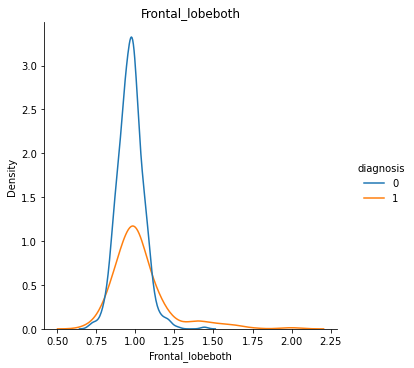

In [4]:
biomarker = biomarkers[0]
sns.displot(data=data, # our dataframe
            x=biomarker, # name of the the distribution we want to plot
            hue='diagnosis', # the "grouping" variable
            kind='kde') # kind can also be 'hist' or 'ecdf'
plt.title(biomarker)
plt.show()

<AxesSubplot:xlabel='age', ylabel='Frontal_lobeboth'>

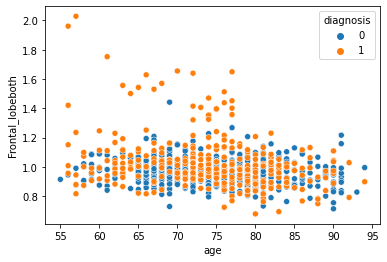

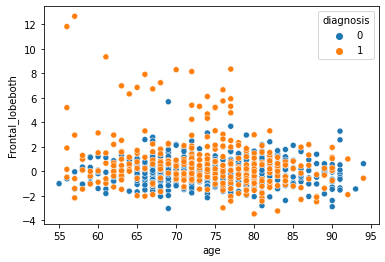

In [5]:
# now we perform the normalization

# make a copy of our dataframe (we don't want to overwrite our original data)
zdata = pandas.DataFrame(data,copy=True)

# for each biomarker
for biomarker in biomarkers:
    mod = smf.ols('%s ~ age'%biomarker,  # fit a model finding the effect of age and headsize on biomarker
                  data=data[data.diagnosis==0] # fit this model *only* to individuals in the control group
                 ).fit() # fit model    
    #print(mod.summary())
    
    # get the "predicted" values for all subjects based on the control model parameters
    predicted = mod.predict(data[['age', biomarker]]) 
    
    # calculate our zscore: observed - predicted / SD of the control group residuals
    w_score = (data.loc[:,biomarker] - predicted) / mod.resid.std()
    
    #print(np.mean(w_score[data.Diagnosis==0]))
    #print(np.std(w_score[data.Diagnosis==0]))
    
    # save zscore back into our new (copied) dataframe
    zdata.loc[:,biomarker] = w_score
    
    
plt.figure(0)
sns.scatterplot(x=data.age,y=data.Frontal_lobeboth,hue=data.diagnosis)
plt.figure(1)
sns.scatterplot(x=zdata.age,y=zdata.Frontal_lobeboth,hue=zdata.diagnosis)

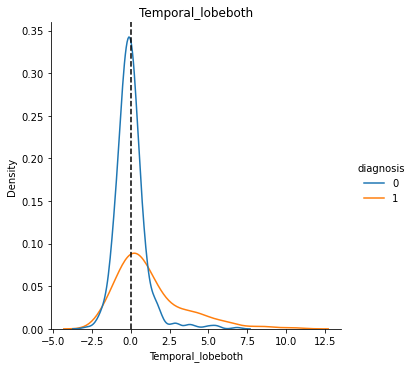

In [6]:
biomarker = biomarkers[1]
sns.displot(data=zdata,x=biomarker,hue='diagnosis',kind='kde')
plt.title(biomarker)
plt.axvline(0,ls='--',c='black') # the 0 line *should* be the mean of the control distribution
plt.show()

In [7]:
N = len(biomarkers)         # number of biomarkers

SuStaInLabels = biomarkers
Z_vals = np.array([[1,2,3]]*N)     # Z-scores for each biomarker
Z_max  = np.array([5]*N)           # maximum z-score

In [8]:
# Input the settings for z-score SuStaIn
# To make the tutorial run faster I've set 
# N_startpoints = 10 and N_iterations_MCMC = int(1e4)
# I recommend using N_startpoints = 25 and 
# N_iterations_MCMC = int(1e5) or int(1e6) in general though

N_startpoints = 2
N_S_max = 3
N_iterations_MCMC = int(1e4)
output_folder = os.path.join(os.getcwd(), 'AdniOutput')
dataset_name = 'AdniOutput'

# Initiate the SuStaIn object
sustain_input = pySuStaIn.ZscoreSustain(
                              zdata[biomarkers].values,
                              Z_vals,
                              Z_max,
                              SuStaInLabels,
                              N_startpoints,
                              N_S_max, 
                              N_iterations_MCMC, 
                              output_folder, 
                              dataset_name, 
                              False)

In [9]:
# make the output directory if it's not already created
if not os.path.isdir(output_folder):
    os.mkdir(output_folder)

In [10]:
samples_sequence,   \
samples_f,          \
ml_subtype,         \
prob_ml_subtype,    \
ml_stage,           \
prob_ml_stage,      \
prob_subtype_stage  = sustain_input.run_sustain_algorithm()

Failed to find pickle file: D:\Projects\d2is\pySustain\AdniOutput\pickle_files\AdniOutput_subtype0.pickle. Running SuStaIn model for 0 subtype.
Finding ML solution to 1 cluster problem
Overall ML likelihood is -15719.531786721207


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

Failed to find pickle file: D:\Projects\d2is\pySustain\AdniOutput\pickle_files\AdniOutput_subtype1.pickle. Running SuStaIn model for 1 subtype.
Splitting cluster 1 of 1
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-15373.08219116]
Overall ML likelihood is [-15373.08219116]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

Failed to find pickle file: D:\Projects\d2is\pySustain\AdniOutput\pickle_files\AdniOutput_subtype2.pickle. Running SuStaIn model for 2 subtype.
Splitting cluster 1 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-15305.17636837]
Splitting cluster 2 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-15299.68095297]
Overall ML likelihood is [-15299.68095297]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

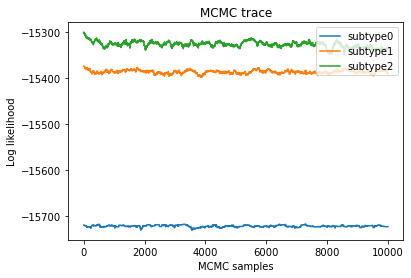

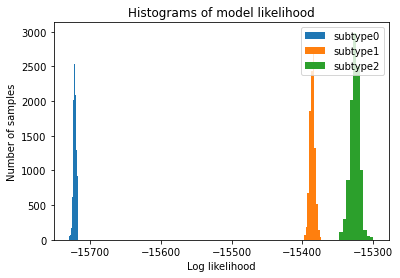

In [11]:
# for each subtype model
for s in range(N_S_max):
    # load pickle file (SuStaIn output) and get the sample log likelihood values
    pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
    pk = pandas.read_pickle(pickle_filename_s)
    samples_likelihood = pk["samples_likelihood"]
    
    # plot the values as a line plot
    plt.figure(0)
    plt.plot(range(N_iterations_MCMC), samples_likelihood, label="subtype" + str(s))
    plt.legend(loc='upper right')
    plt.xlabel('MCMC samples')
    plt.ylabel('Log likelihood')
    plt.title('MCMC trace')
    
    # plot the values as a histogramp plot
    plt.figure(1)
    plt.hist(samples_likelihood, label="subtype" + str(s))
    plt.legend(loc='upper right')
    plt.xlabel('Log likelihood')  
    plt.ylabel('Number of samples')  
    plt.title('Histograms of model likelihood')


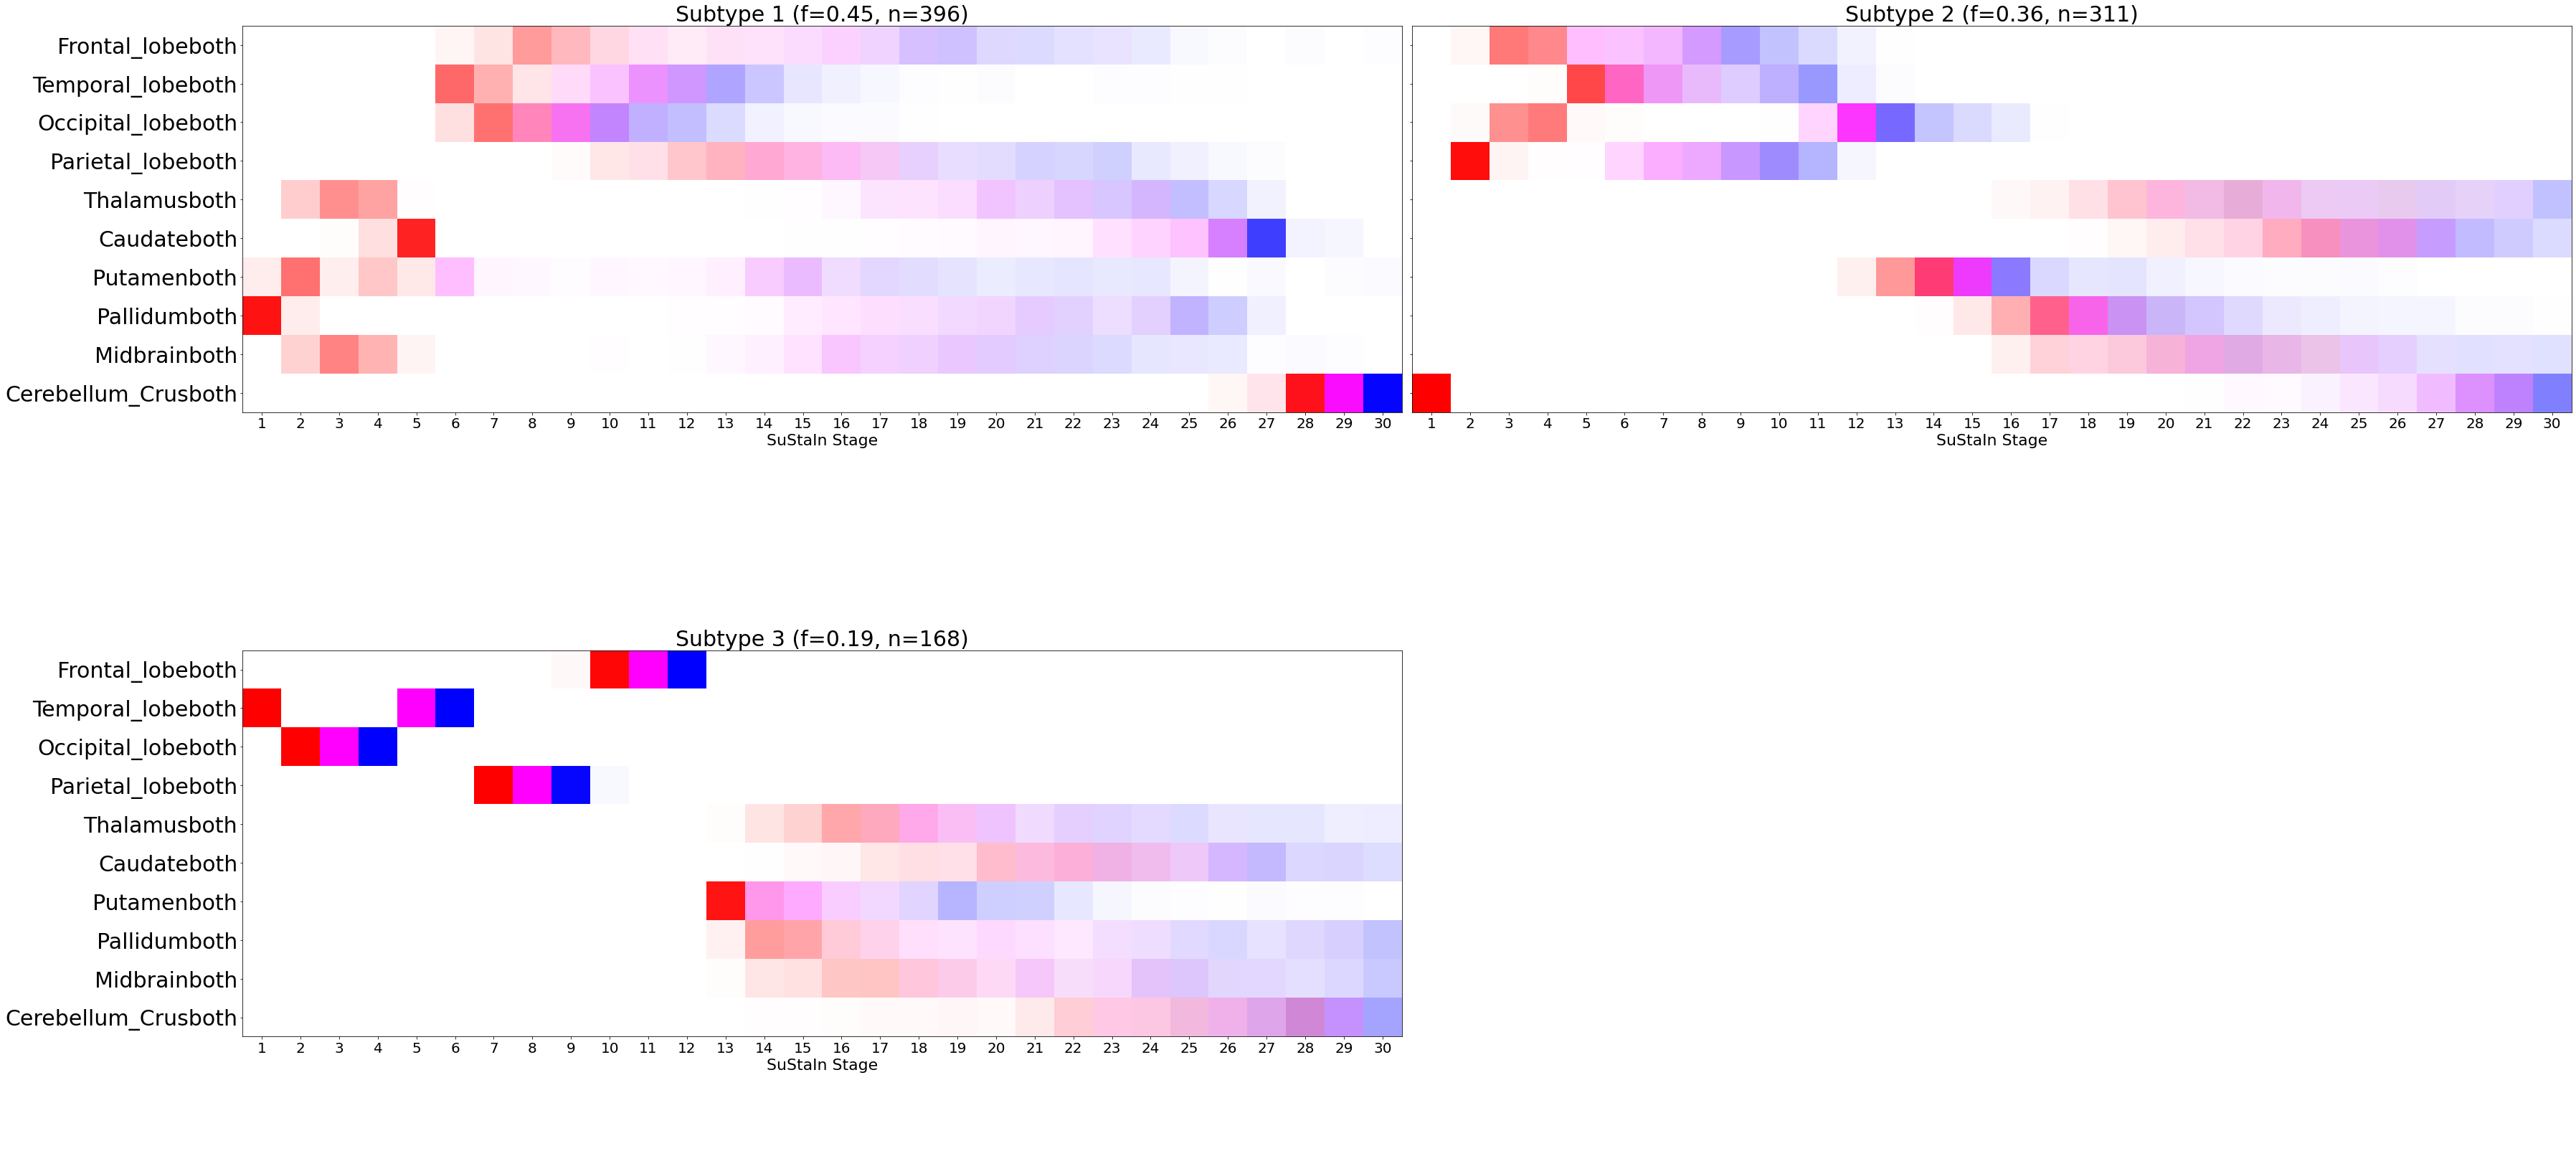

In [14]:
# Let's plot positional variance diagrams to interpret the subtype progressions

s = 2 # 1 split = 2 subtypes
M = len(zdata) 

# get the sample sequences and f
pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
pk = pandas.read_pickle(pickle_filename_s)
samples_sequence = pk["samples_sequence"]
samples_f = pk["samples_f"]

# use this information to plot the positional variance diagrams
tmp=pySuStaIn.ZscoreSustain._plot_sustain_model(sustain_input,
                                                samples_sequence,
                                                samples_f,
                                                M,
                                                biomarker_labels=biomarkers,
                                                figsize=(50, 25),
                                                title_font_size=30, 
                                                stage_font_size=20,
                                                label_font_size=30)